In [1]:
!pip install -q transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from transformers import BertTokenizer, BertModel
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [3]:
# Определим константу для пути к данным. Замените «My Drive» фактическим путем к вашей директории данных.
DATA_PATH = '/content/drive/My Drive'

# Подключимся к Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Создадим полные пути для экспертных и массовых аннотаций, используя DATA_PATH.
expert_annotations_path = os.path.join(DATA_PATH, 'ExpertAnnotations.tsv')
crowd_annotations_path = os.path.join(DATA_PATH, 'CrowdAnnotations.tsv')

# Загрузим датафреймы, используя полные пути
expert_annotations_df = pd.read_csv(expert_annotations_path, sep='\t', header=None)
crowd_annotations_df = pd.read_csv(crowd_annotations_path, sep='\t', header=None)

***Переименуем безымянные названия столбцов чтобы в дальнейшем было удобно по ним обьединить нужные столбцы в единый обучающий датасет.***

In [5]:
# Именование столбцов файла CrowdAnnotations.tsv согласно приведенному описанию.
crowd_annotations_df.columns = [
    'image',
    'description_id',
    'percentage_of_matches',
    'number_of_confirmations',
    'number_of_rejections'
]

# Именование столбцов файла ExpertAnnotations.tsv согласно приведенному описанию.
expert_annotations_df.columns = [
    'image',
    'description_id',
    'expert_1_rating',
    'expert_2_rating',
    'expert_3_rating'
]

display(expert_annotations_df.head(10))
print()
display(crowd_annotations_df.head(10))

,image,description_id,expert_1_rating,expert_2_rating,expert_3_rating
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2


,image,description_id,percentage_of_matches,number_of_confirmations,number_of_rejections
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3


In [6]:
expert_annotations_df.info()
print()
crowd_annotations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image            5822 non-null   object
 1   description_id   5822 non-null   object
 2   expert_1_rating  5822 non-null   int64 
 3   expert_2_rating  5822 non-null   int64 
 4   expert_3_rating  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   image                    47830 non-null  object 
 1   description_id           47830 non-null  object 
 2   percentage_of_matches    47830 non-null  float64
 3   number_of_confirmations  47830 non-null  int64  
 4   number_of_rejections     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)


In [7]:
# Нам необходимо соответствующим образом подготовить данные.
# Мы преобразуем рейтинги экспертов в шкалу от 0 до 1, чтобы соответствовать шкале процента краудсорса.

# Нормализуем экспертные оценки по шкале 0-1
expert_annotations_df['Normalized Expert 1'] = (expert_annotations_df['expert_1_rating'] - 1) / 3
expert_annotations_df['Normalized Expert 2'] = (expert_annotations_df['expert_2_rating'] - 1) / 3
expert_annotations_df['Normalized Expert 3'] = (expert_annotations_df['expert_3_rating'] - 1) / 3

# Рассчитаем средний экспертный рейтинг
expert_annotations_df['mean_expert_rating'] = expert_annotations_df[
    ['Normalized Expert 1', 'Normalized Expert 2', 'Normalized Expert 3']].mean(axis=1)

In [8]:
# Присвоим веса экспертным и краудсорсинговым аннотациям.
expert_weight = 0.6
crowd_weight = 0.4

# Выполнить внешнее соединение (outer merge)
merged_annotations_outer = pd.merge(
    crowd_annotations_df,
    expert_annotations_df,
    how='outer',
    on=['image', 'description_id']
)

# Расчет медианы краудсорса
median_crowd_percentage = merged_annotations_outer['percentage_of_matches'].median()
# Расчет медианы экспертов
median_expert_rating = merged_annotations_outer['mean_expert_rating'].median()

# Заполним пропущенные значения медианой
merged_annotations_outer['normalized_crowd_percentage'] = merged_annotations_outer[
    'percentage_of_matches'].fillna(median_crowd_percentage)
merged_annotations_outer['mean_expert_rating'] = merged_annotations_outer[
    'mean_expert_rating'].fillna(median_expert_rating)

# Рассчитаем взвешенный комбинированный балл
merged_annotations_outer['weighted_combined_score'] = (
    (merged_annotations_outer['mean_expert_rating'] * expert_weight) +
    (merged_annotations_outer['normalized_crowd_percentage'] * crowd_weight)
)

# Выберем только необходимые столбцы и назначим их датафрейму annotations_df.
annotations_df = merged_annotations_outer[['image', 'description_id', 'weighted_combined_score']]

# Отобразим первые несколько строк annotations_df для проверки.
annotations_df.head()

,image,description_id,weighted_combined_score
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,0.466667
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.066667
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.066667
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.066667
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.066667


In [9]:
annotations_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   image                    51323 non-null  object 
 1   description_id           51323 non-null  object 
 2   weighted_combined_score  51323 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [10]:
# Чтобы понять сокращение количества записей, мы проверим охват и согласованность
# 'image' и 'description_id' как в датафрейме краудсорса, так и в экспертных аннотациях.

# Количество уникальных 'image' и 'description_id'  в обоих наборах данных
unique_crowd_images = crowd_annotations_df['image'].nunique()
unique_expert_images = expert_annotations_df['image'].nunique()
unique_crowd_descriptions = crowd_annotations_df['description_id'].nunique()
unique_expert_descriptions = expert_annotations_df['description_id'].nunique()

# Проверка любых расхождений в форматировании или проблем с сопоставлением
# Мы посмотрим на пересечения наборов уникальных идентификаторов, чтобы увидеть,
# сколько из них являются общими.
shared_image_files = set(
    crowd_annotations_df['image']).intersection(set(expert_annotations_df['image']))
shared_description_ids = set(
    crowd_annotations_df['description_id']).intersection(set(expert_annotations_df['description_id']))

# Подсчитаем количество общих идентификаторов
num_shared_image_files = len(shared_image_files)
num_shared_description_ids = len(shared_description_ids)

print(unique_crowd_images, unique_expert_images, unique_crowd_descriptions,
      unique_expert_descriptions, num_shared_image_files, num_shared_description_ids)

1000 1000 1000 977 1000 977


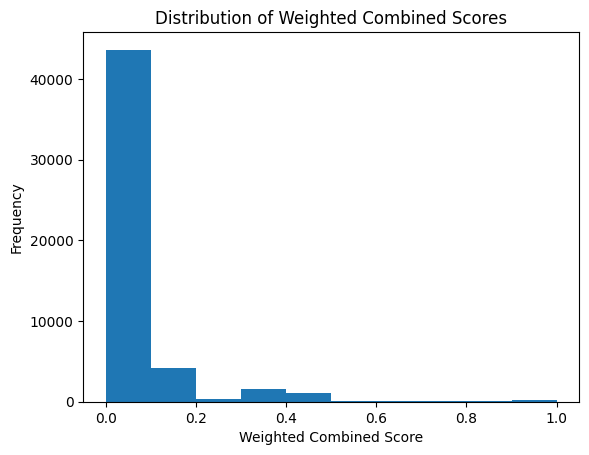

(count    51323.000000
 mean         0.099440
 std          0.111892
 min          0.000000
 25%          0.066667
 50%          0.066667
 75%          0.066667
 max          1.000000
 Name: weighted_combined_score, dtype: float64,
 1000,
 1000)

In [11]:
# 1. Распределение взвешенного комбинированного балла
score_description = annotations_df['weighted_combined_score'].describe()
score_histogram = annotations_df['weighted_combined_score'].hist()
plt.title('Distribution of Weighted Combined Scores')
plt.xlabel('Weighted Combined Score')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# 2. Разнообразие изображений
unique_images = annotations_df['image'].nunique()

# 3. Разнообразие описаний
unique_descriptions = annotations_df['description_id'].nunique()

score_description, unique_images, unique_descriptions

На представленном графике показаны результаты процесса анализа данных, включая распределение «взвешенных комбинированных оценок» и количество уникальных имен файлов изображений и идентификаторов описаний по двум наборам данных (аннотации, полученные из краудсорсинга, и экспертные аннотации). Вот интерпретация отображаемых результатов:

### Распределение взвешенных комбинированных баллов
Гистограмма иллюстрирует распределение «взвешенных комбинированных оценок», которые являются показателем, полученным как на основе краудсорсинговых, так и экспертных оценок. Вывод метода `.describe()` предоставляет сводную статистику этих оценок:
- **count**: В наборе данных 51.323 записи, что указывает на значительный объем данных для анализа и обучения модели.
- **Среднее**: средний балл составляет примерно 0.099.
- **Стандартное отклонение (стандартное)**: стандартное отклонение оценок составляет примерно 0.112, что указывает на умеренную вариабельность оценок.
- **Минимум (мин)**: Минимальный балл равен 0, что указывает на то, что существуют пары изображений и описаний, которые полностью не соответствуют согласно оценкам.
- **25-й процентиль**: 25 % оценок ниже примерно 0.067.
- **50-й процентиль (медиана)**: средний балл составляет 0.067.
- **75-й процентиль**: 75 % оценок ниже примерно 0.067.
- **25-й, 50-й (медиана) и 75-й процентили равны примерно 0,067**. Такая однородность по квартилям указывает на концентрацию баллов вокруг этого значения. Согласованность этих значений процентилей предполагает, что значительная часть набора данных имеет одинаковый уровень соответствия между изображениями и описаниями в соответствии с системой взвешенной оценки.
- **Максимум (макс.)**: Максимальный балл равен 1, что показывает, что некоторые пары «изображение-описание» идеально совпадают в соответствии с совокупными оценками толпы и экспертов.

**Анализ гистограммы и последствия для моделирования**

- ***Чувствительность модели***: модель должна быть достаточно чувствительной, чтобы различать различные степени соответствия, тем более что большая часть данных сосредоточена вокруг медианного значения.
- ***Обработка асимметрии***: Правильная асимметрия данных может повлиять на способность модели точно прогнозировать более высокие оценки. При рассмотрении таких случаев может потребоваться особое внимание.
- ***Представление данных***: гистограмма показывает, что данные предоставляют хороший диапазон сценариев: от отсутствия совпадения до идеального совпадения, что полезно для обучения надежной модели.

В целом гистограмма указывает на разумное распределение оценок со значительной концентрацией вокруг медианы, подходящее для обучения и оценки модели, целью которой является сопоставление изображений с описаниями.

### Анализ идентификатора изображения и описания
- **Уникальные изображения толпы**: 1000 уникальных имен файлов изображений в наборе данных, полученном из краудсорсинга.
- **Уникальные экспертные изображения**: 1000 уникальных имен файлов изображений в наборе экспертных данных.
- **Уникальные описания толпы**: 1000 уникальных идентификаторов описаний в наборе краудсорсинговых данных.
- **Уникальные описания экспертов**: 977 уникальных идентификаторов описаний в наборе экспертных данных.
- **Общие файлы изображений**: все 1000 имен файлов изображений используются совместно краудсорсинговыми и экспертными наборами данных.
- **Общие идентификаторы описаний**: в двух наборах данных имеется 977 общих идентификаторов описаний.

### Интерпретация:
- **Согласованность между наборами данных**. В именах файлов изображений между краудсорсинговыми и экспертными наборами данных наблюдается высокий уровень согласованности, при этом все файлы изображений присутствуют в обоих. Однако существует небольшое расхождение в идентификаторах описаний: в наборе краудсорсинговых данных присутствует 23 уникальных описания, которых нет в наборе экспертных данных.
- **Описательная статистика баллов**: взвешенные комбинированные баллы смещены в сторону нижнего предела шкалы, при этом медиана ниже среднего значения. Это указывает на то, что больше аннотаций имеют оценку ниже среднего.
- **Последствия для дальнейшего анализа**: наличие двух пиков в распределении баллов требует дальнейшего изучения. Возможно, было бы полезно понять характеристики аннотаций, получивших высокие и низкие оценки, и коррелируют ли они с конкретными особенностями изображений или описаний.
- **Полнота данных**. Расхождение в идентификаторах описаний позволяет предположить, что краудсорсинговый набор данных может содержать дополнительные аннотации, не оцененные экспертами. Дальнейшее изучение этих дополнительных описаний могло бы дать представление о том, представляют ли они пробел в экспертном анализе или были исключены по определенным причинам.

Этот анализ необходим для понимания согласия между различными источниками аннотаций и качества аннотаций. Он может направлять разработку моделей, основанных на этих аннотациях, принимать решения о том, каким аннотациям доверять или отдавать приоритет, а также предлагать области, в которых сам процесс аннотирования может быть улучшен или дополнительно изучен.

# Проверка данных

In [12]:
# Загрузим датасет
file_path = os.path.join(DATA_PATH, 'train_dataset.csv')
train_dataset = pd.read_csv(file_path)

# Отобразим первые несколько строк набора данных и его основную информацию.
train_dataset.info()
print()
display(train_dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB



,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [13]:
# Определим список запрещенных ключевых слов.
restricted_keywords = ['minor', "child", "children", "toddlers",
                       "kid", "boy", "girl", "school", "playground"]

# Функция проверки наличия в описании каких-либо запрещенных ключевых слов.
def contains_restricted_keyword(text, keywords):
    text = text.lower()
    return any(keyword in text for keyword in keywords)

# Шаг 1. Выявим плохие комментарии
train_dataset['is_bad_comment'] = train_dataset['query_text'].apply(
    lambda x: contains_restricted_keyword(x, restricted_keywords))

# Шаг 2. Определим список плохих изображений на основе плохих комментариев.
# Отрезаем два последних символа query_id плохих комментариев, чтобы получить список плохих изображений
bad_images = set(train_dataset[train_dataset['is_bad_comment']]['query_id'].apply(lambda x: x[:-2]))

# Шаг 3. Удаляем из нашего набора данных все пары изображений и описаний с плохими изображениями.
filtered_train_df = train_dataset[~train_dataset['image'].isin(bad_images)]

# Отображение результата фильтрации
original_count = len(train_dataset)
filtered_count = len(filtered_train_df)

print(original_count, filtered_count)
print()
filtered_train_df.info()
print()
display(filtered_train_df.head())

5822 4145

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4145 entries, 0 to 5820
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image           4145 non-null   object
 1   query_id        4145 non-null   object
 2   query_text      4145 non-null   object
 3   is_bad_comment  4145 non-null   bool  
dtypes: bool(1), object(3)
memory usage: 133.6+ KB



,image,query_id,query_text,is_bad_comment
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,True
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,True
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,True
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,True
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,True


In [14]:
# Шаг 1. Переименуем столбцы в filtered_train_df, чтобы они соответствовали annotations_df.
filtered_train_df.rename(columns={'query_id': 'description_id'}, inplace=True)

# Шаг 2. Объединим annotations_df с filtered_train_df
pre_train_df = pd.merge(annotations_df, filtered_train_df, on=['image', 'description_id'])

# Проверка результата
pre_train_df.info()
print()
display(pre_train_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4145 entries, 0 to 4144
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   image                    4145 non-null   object 
 1   description_id           4145 non-null   object 
 2   weighted_combined_score  4145 non-null   float64
 3   query_text               4145 non-null   object 
 4   is_bad_comment           4145 non-null   bool   
dtypes: bool(1), float64(1), object(3)
memory usage: 166.0+ KB



<ipython-input-14-3cd6a523eeda>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train_df.rename(columns={'query_id': 'description_id'}, inplace=True)


,image,description_id,weighted_combined_score,query_text,is_bad_comment
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,A young child is wearing blue goggles and sitt...,True
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.066667,A girl wearing a yellow shirt and sunglasses s...,True
2,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,0.066667,A man and woman look back at the camera while ...,False
3,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,0.200000,A crowd of people at an outdoor event,False
4,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,0.466667,Close-up of dog in profile with mouth open .,False


In [15]:
pre_train_df = pre_train_df[['image', 'description_id',
                             'query_text', 'weighted_combined_score']]
pre_train_df.info()
print()
display(pre_train_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4145 entries, 0 to 4144
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   image                    4145 non-null   object 
 1   description_id           4145 non-null   object 
 2   query_text               4145 non-null   object 
 3   weighted_combined_score  4145 non-null   float64
dtypes: float64(1), object(3)
memory usage: 161.9+ KB



,image,description_id,query_text,weighted_combined_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.066667
2,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,A man and woman look back at the camera while ...,0.066667
3,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,A crowd of people at an outdoor event,0.200000
4,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,Close-up of dog in profile with mouth open .,0.466667


# Векторизация текстов

In [16]:
# Функция кодирования текста с использованием BERT с помощью графического процессора
def bert_encode(text, model, tokenizer, device):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)

    # Получим выходные данные (последние скрытые состояния) из модели BERT.
    with torch.no_grad():
        last_hidden_states = model(input_ids)[0]

    # Переместим результат обратно в ЦП и преобразуем в numpy
    return last_hidden_states[0][0].cpu().numpy()

# Проверим доступность графического процессора
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Загрузим предварительно обученный токенизатор модели и модель и отправим модель в графический процессор.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Векторизуем текстовые описания
pre_train_df['bert_vector'] = pre_train_df['query_text'].apply(lambda x: bert_encode(x, model, tokenizer, device))

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [17]:
pre_train_df.head()

,image,description_id,query_text,weighted_combined_score,bert_vector
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,"[-0.047877356, 0.05141468, -0.27281278, -0.072..."
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.066667,"[0.3064611, 0.18739626, -0.31747952, -0.147754..."
2,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,A man and woman look back at the camera while ...,0.066667,"[0.20837602, 0.19895823, 0.058023393, -0.02440..."
3,1082379191_ec1e53f996.jpg,1536774449_e16b1b6382.jpg#2,A crowd of people at an outdoor event,0.200000,"[-0.014534058, -0.039590366, -0.2054309, 0.139..."
4,1084040636_97d9633581.jpg,256085101_2c2617c5d0.jpg#2,Close-up of dog in profile with mouth open .,0.466667,"[-0.78212327, -0.5189205, -0.44774392, 0.03597..."


In [18]:
pre_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4145 entries, 0 to 4144
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   image                    4145 non-null   object 
 1   description_id           4145 non-null   object 
 2   query_text               4145 non-null   object 
 3   weighted_combined_score  4145 non-null   float64
 4   bert_vector              4145 non-null   object 
dtypes: float64(1), object(4)
memory usage: 194.3+ KB


In [19]:
# Выберем один вектор из датафрейма, чтобы проверить его размерность.
sample_vector = pre_train_df['bert_vector'].iloc[0]

# Распечатаем размерность вектора выборки
print(f"Размерность вектора BERT равна: {sample_vector.shape}")

Размерность вектора BERT равна: (768,)


Чтобы векторизировать тексты с помощью BERT из Hugging Face Transformers, были выполнены следующие действия:

1. **Настройка среды**: установлена необходимая библиотека из Hugging Face - transformers.
2. **Загрузка предварительно обученной модели BERT и токенизатора**: Использована предварительно обученная модель BERT, подходящая для наших нужд, вместе с соответствующим токенизатором.
3. **Предварительная обработка и токенизация текста**: Подготовлены текстовые данные для модели, включая их токенизацию и правильное форматирование.
4. **Генерация эмбеддингов**: токенизированный текст был передан модели, чтобы получить эмбеддинги - числовые векторы.

# Векторизация изображений

In [20]:
image_dir = os.path.join(DATA_PATH, 'train_images')

In [21]:
# Убедимся, что TensorFlow использует графический процессор (если доступен).
tf.device('/device:GPU:0')

# Загрузим модель ResNet50, предварительно обученную на данных ImageNet (в автоматическом режиме).
tf.get_logger().setLevel('ERROR')
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Функция для преобразования изображений в векторы с помощью ResNet50
def resnet50_encode(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded)

    features = resnet_model.predict(img_preprocessed, verbose=0)
    return features.flatten()

# Инициализируем список для хранения имен файлов изображений и соответствующих им векторов.
image_data = []
# Пройдемся по директории и обработаем каждое изображение.
for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    if os.path.isfile(img_path):  # Убеждаемся, что это файл, а не под-директория
        img_vector = resnet50_encode(img_path)
        image_data.append({'image': img_name, 'resnet50_vector': img_vector})

# Преобразование списка словарей в DataFrame
image_vectors_df = pd.DataFrame(image_data)
image_vectors_df

94765736/94765736 [==============================] - 0s 0us/step


,image,resnet50_vector
0,510531976_90bbee22a2.jpg,"[0.27306557, 0.7899623, 0.03319925, 1.2073627,..."
1,2762301555_48a0d0aa24.jpg,"[0.4480564, 1.0786641, 0.18887384, 0.9539038, ..."
2,300314926_0b2e4b64f5.jpg,"[0.7242572, 0.20963274, 0.099216335, 0.0076660..."
3,3286822339_5535af6b93.jpg,"[0.3958953, 1.1315533, 0.0047899596, 0.4610124..."
4,3502343542_f9b46688e5.jpg,"[0.35710073, 1.143127, 0.46283185, 0.0, 0.0, 0..."
...,...,...
995,3108197858_441ff38565.jpg,"[0.46488023, 0.8818283, 0.11253191, 3.759429, ..."
996,3397220683_4aca010f86.jpg,"[1.552202, 3.1731007, 0.28125498, 0.2180369, 0..."
997,1224851143_33bcdd299c.jpg,"[0.6418191, 0.1550817, 0.6333874, 2.7627277, 0..."
998,2351479551_e8820a1ff3.jpg,"[0.09802001, 0.008783078, 0.038294923, 0.36819..."


In [22]:
image_vectors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image            1000 non-null   object
 1   resnet50_vector  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


In [28]:
# Объединение pre_train_df с image_vectors_df по 'Image file name'
final_train_df = pd.merge(pre_train_df, image_vectors_df, on='image')
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4145 entries, 0 to 4144
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   image                    4145 non-null   object 
 1   description_id           4145 non-null   object 
 2   query_text               4145 non-null   object 
 3   weighted_combined_score  4145 non-null   float64
 4   bert_vector              4145 non-null   object 
 5   resnet50_vector          4145 non-null   object 
dtypes: float64(1), object(5)
memory usage: 226.7+ KB


In [29]:
final_train_df.head()

,image,description_id,query_text,weighted_combined_score,bert_vector,resnet50_vector
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.000000,"[-0.047877356, 0.05141468, -0.27281278, -0.072...","[0.08656639, 0.0011649764, 0.0, 2.4696376, 0.0..."
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...,0.066667,"[0.3064611, 0.18739626, -0.31747952, -0.147754...","[0.08656639, 0.0011649764, 0.0, 2.4696376, 0.0..."
2,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,A man and woman look back at the camera while ...,0.066667,"[0.20837602, 0.19895823, 0.058023393, -0.02440...","[0.08656639, 0.0011649764, 0.0, 2.4696376, 0.0..."
3,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,0.066667,"[0.22594531, -0.14776902, -0.41042653, 0.00985...","[0.08656639, 0.0011649764, 0.0, 2.4696376, 0.0..."
4,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...,0.133333,"[0.3637189, 0.16300847, -0.49055305, 0.0199273...","[0.08656639, 0.0011649764, 0.0, 2.4696376, 0.0..."


In [26]:
# Выберем один вектор из датафрейма, чтобы проверить его размерность.
sample_image_vector = final_train_df['resnet50_vector'].iloc[0]

# Распечатаем размер образца векторного изображения.
print(f"Размерность вектора изображения ResNet50 равна: {sample_image_vector.shape}")

Размерность вектора изображения ResNet50 равна: (2048,)


Учитывая размеры векторов изображения и текста, полученных из ResNet50 и BERT соответственно, мы можем детализировать полученные пары векторов следующим образом:

1. **Размер вектора изображения ResNet50**: (2048,)
    — Каждое изображение представлено вектором длиной 2048, который является результатом модели ResNet50 после обработки изображения.

2. **Размер вектора текста BERT**: (768,)
    — Каждое текстовое описание представлено вектором длиной 768, полученным из модели BERT.

### Объединенный вектор для входных данных модели

Для создания модели, которая оценивает близость изображения и текстового описания, нам необходимо объединить эти два вектора. Полученный объединенный вектор будет иметь следующие свойства:

- **Размер конкатенированного вектора**: (2048 + 768) = (2816)
    - Это получается простым сложением размеров отдельных векторов.
    - Объединенный вектор эффективно сочетает в себе признаки, извлеченные как из изображения, так и из текстового описания.

### Использование в модели

- Объединенный вектор размерности (2816) будет использоваться в качестве входных данных для модели машинного обучения.
- Эта модель научится прогнозировать итоговую оценку экспертов на основе совокупности признаков векторов текста и изображения.
- Модель может представлять собой линейную регрессию, полностью связанную нейронную сеть или любую другую подходящую модель, способную обрабатывать эту размерность и выполнять задачи регрессии.

### Заключение

Комбинированный вектор изображений и текстовых представлений обеспечивает полный набор признаков, на которых модель может учиться. Он инкапсулирует как визуальную, так и текстовую информацию, что имеет решающее значение для точного прогнозирования экспертной оценки соответствия изображения и его описания. Размерность (2816) должна быть приемлемой для большинства современных сред машинного обучения и обеспечивать эффективное обучение и прогнозирование.

# Обучение модели

In [30]:
# Конкатенируем «bert_vector» и «resnet50_vector», чтобы создать один вектор признаков.
X = np.hstack((np.array(final_train_df['bert_vector'].tolist()),
               np.array(final_train_df['resnet50_vector'].tolist())))

# Целевая переменная 'Weighted Combined Score'
y = final_train_df['weighted_combined_score'].values

# Определим группы
groups = final_train_df['image'].values

# Инициализируем GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Получим индексы для первого разделения
train_idx, test_idx = next(gss.split(X, y, groups=groups))

# Разделение данных на обучающие и тестовые наборы с использованием индексов
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3311, 2816) (834, 2816) (3311,) (834,)


## Модель 1: Линейная регрессия

In [34]:
# Инициализируем и обучим модель линейной регрессии
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Прогнозирование на основе тестовых данных
y_pred_lr = lr_model.predict(X_test)

# Оценка модели
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print("Linear Regression - MSE:", mse_lr)
print("Linear Regression - RMSE:", rmse_lr)

Linear Regression - MSE: 2132.1477930101614
Linear Regression - RMSE: 46.17518590119764


## Модель 2: Полносвязная нейронная сеть (с использованием Keras)

In [35]:
# Инициализация модели
nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

# Компиляция модели
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Прогнозирование на основе тестовых данных
y_pred_nn = nn_model.predict(X_test).flatten()

# Оценка модели
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)

print("Neural Network - MSE:", mse_nn)
print("Neural Network - RMSE:", rmse_nn)

Epoch 1/10
40/40 [==============================] - 2s 16ms/step - loss: 0.2511 - val_loss: 0.0970
Epoch 2/10
40/40 [==============================] - 0s 10ms/step - loss: 0.0661 - val_loss: 0.0665
Epoch 3/10
40/40 [==============================] - 1s 14ms/step - loss: 0.0588 - val_loss: 0.1007
Epoch 4/10
40/40 [==============================] - 0s 9ms/step - loss: 0.0579 - val_loss: 0.0659
Epoch 5/10
40/40 [==============================] - 1s 13ms/step - loss: 0.0484 - val_loss: 0.0714
Epoch 6/10
40/40 [==============================] - 0s 11ms/step - loss: 0.0522 - val_loss: 0.0598
Epoch 7/10
40/40 [==============================] - 0s 11ms/step - loss: 0.0414 - val_loss: 0.0700
Epoch 8/10
40/40 [==============================] - 0s 12ms/step - loss: 0.0378 - val_loss: 0.0700
Epoch 9/10
40/40 [==============================] - 0s 10ms/step - loss: 0.0424 - val_loss: 0.0767
Epoch 10/10
13/13 [==============================] - 0s 7ms/step
Neural Network - MSE: 0.07229131805029682
Neu

1. **Линейная регрессия**:
- Чрезвычайно высокое MSE и RMSE указывают на то, что модель работает очень плохо. Это может быть связано с переобучением, недообучением или какой-либо проблемой с данными.

2. **Нейронная сеть**:
- MSE значительно ниже по сравнению с линейной регрессией, что предполагает, что модель прогнозирует значения, более близкие к фактическим значениям, но она все еще не идеальна из-за относительно высокого значения RMSE.

***Однако этого может быть достаточно на данном экспериментальном этапе в соответствии с задачей PoC (Proof of Concept, Проверка концепции)!***

# Тестирование модели и демонстрация ее работы

In [22]:
file_path = os.path.join(DATA_PATH, 'test_queries.csv')

# Попытка загрузить первые несколько строк для проверки данных
try:
    test_queries_df = pd.read_csv(file_path, delimiter='|', on_bad_lines='skip')
    error_message = "File read with specific delimiter and skipping bad lines."
except Exception as e:
    test_queries_df = None
    error_message = str(e)

test_queries_df.info()
print()
display(test_queries_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB



,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [23]:
test_queries_df = test_queries_df.drop('Unnamed: 0', axis=1)
test_queries_df.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [38]:
# Векторизируем текстовые описания
test_queries_df['bert_vector'] = test_queries_df['query_text'].apply(lambda x: bert_encode(x, model, tokenizer, device))
test_queries_df.head()

,query_id,query_text,image,bert_vector
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg,"[0.53365856, 0.3410318, -0.7350272, -0.2370491..."
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg,"[0.47315055, 0.555789, -0.39326307, -0.4037168..."
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg,"[-0.2510616, 0.45821983, -0.8315012, 0.1565032..."
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg,"[0.25195917, 0.55996746, -0.68001604, -0.05404..."
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg,"[0.6404591, 0.6084136, -0.45739517, -0.4459099..."


In [39]:
test_queries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   query_id     500 non-null    object
 1   query_text   500 non-null    object
 2   image        500 non-null    object
 3   bert_vector  500 non-null    object
dtypes: object(4)
memory usage: 15.8+ KB


In [40]:
test_images_dir = os.path.join(DATA_PATH, 'test_images')

image_data = []
for img_name in os.listdir(test_images_dir):
    # Пропускаем любой файл, который не заканчивается на .jpg.
    if not img_name.lower().endswith('.jpg'):
        continue

    img_path = os.path.join(test_images_dir, img_name)
    if os.path.isfile(img_path):
        img_vector = resnet50_encode(img_path)
        image_data.append({'image': img_name, 'resnet50_vector': img_vector})

# Преобразование списка словарей в DataFrame
test_images_df = pd.DataFrame(image_data)
display(test_images_df.head())
print()
test_images_df.info()

                       image  \
0  2107838729_a527e434bd.jpg   
1  3211199368_ca78387f72.jpg   
2   607339469_af851c4119.jpg   
3   634891010_9fa189effb.jpg   
4  3044745642_1d0784ff29.jpg   

                                     resnet50_vector  
0  [0.028243933, 0.7627424, 0.13771504, 0.1784217...  
1  [0.40206015, 2.8707848, 5.4086733e-05, 0.34846...  
2  [0.07647104, 0.08675916, 0.60829955, 0.4321112...  
3  [0.9881582, 0.49458075, 0.09000668, 0.30734918...  
4  [0.09150447, 0.7343021, 0.45361352, 0.62804955...  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image            100 non-null    object
 1   resnet50_vector  100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB
None


In [42]:
# Объединение двух датафреймов по столбцу «image»
merged_test_df = test_queries_df.merge(test_images_df, on='image', how='inner')
print(merged_test_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   query_id         500 non-null    object
 1   query_text       500 non-null    object
 2   image            500 non-null    object
 3   bert_vector      500 non-null    object
 4   resnet50_vector  500 non-null    object
dtypes: object(5)
memory usage: 23.4+ KB
None


In [43]:
test_df = merged_test_df[['bert_vector', 'resnet50_vector']]
display(test_df.head())
print()
test_df.info()

                                         bert_vector  \
0  [0.53365856, 0.3410318, -0.7350272, -0.2370491...   
1  [0.47315055, 0.555789, -0.39326307, -0.4037168...   
2  [-0.2510616, 0.45821983, -0.8315012, 0.1565032...   
3  [0.25195917, 0.55996746, -0.68001604, -0.05404...   
4  [0.6404591, 0.6084136, -0.45739517, -0.4459099...   

                                     resnet50_vector  
0  [0.27217522, 1.5763917, 0.0275855, 0.30047524,...  
1  [0.27217522, 1.5763917, 0.0275855, 0.30047524,...  
2  [0.27217522, 1.5763917, 0.0275855, 0.30047524,...  
3  [0.27217522, 1.5763917, 0.0275855, 0.30047524,...  
4  [0.27217522, 1.5763917, 0.0275855, 0.30047524,...  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   bert_vector      500 non-null    object
 1   resnet50_vector  500 non-null    object
dtypes: object(2)
memory usage: 11.7+ KB
None


In [44]:
def predict_similarity(image_vector, query_token):
    combined_vector = np.hstack((np.array(test_df['bert_vector'].tolist()),
                                 np.array(test_df['resnet50_vector'].tolist())))
    prediction = nn_model.predict(combined_vector).flatten()

    return prediction

1/1 [==============================] - 0s 16ms/step


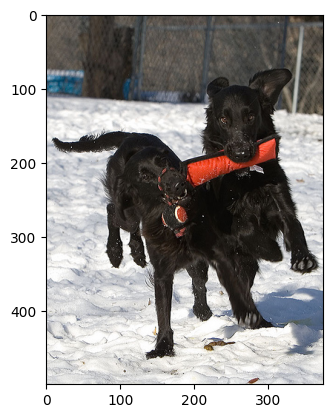

'3154152744_4e93ec8a62.jpg'

In [48]:
def get_image_from_query(query, test_df, nn_model):
    max_score = -1
    best_image = None

    for index, row in test_df.iterrows():
        combined_vector = np.hstack((row['bert_vector'], row['resnet50_vector']))
        prediction = nn_model.predict(combined_vector.reshape(1, -1))[0]

        if prediction > max_score:
            max_score = prediction
            best_image = row['image']

    if best_image is not None:
        img_path = os.path.join(test_images_dir, best_image)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.show()
    else:
        print("No best image found.")

    return best_image

get_image_from_query('running boy in green shorts', merged_test_df, nn_model)

1/1 [==============================] - 0s 18ms/step


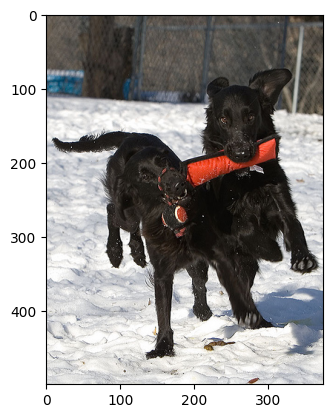

'3154152744_4e93ec8a62.jpg'

In [49]:
get_image_from_query('box', merged_test_df, nn_model)

**Почему-то результат всегда одна и та жа фотография, независимо от входного текста! Не понимаю в чем ошибка, нужна помощь. Спасибо.**